# rt-higgs

In [44]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation
import pandas as pd
%matplotlib inline

In [131]:
# the hiring data itself

df = pd.read_csv('data/rt_occupywallstnyc/rt_occupywallstnyc.txt', 
            names = ('endorsed', 'endorser', 't'))
df['t'] = pd.to_datetime(pd.to_timedelta(df.t, unit='s'))
df['day'] = pd.to_timedelta(df.t - df.t.min())
# df['day'] = np.round(df['day'] / np.timedelta64(1, 'D')).astype(int)
df['hour'] = np.round(df['day'] / np.timedelta64(1, 'h')).astype(int)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


The next step is to transform the data into a sequence of cumulative hiring matrices. 

In [159]:
top = df[['endorsed']].groupby('endorsed').size().nlargest(100)
top = np.array(top.index)
df_ = df[df['endorsed'].isin(top)]
df_ = df_[df_['endorser'].isin(top)]

lookup = {top[i] : i + 10**7  for i in range(len(top))}
df_ = df_.replace({'endorsed' : lookup, 'endorser' : lookup})
df_.endorsed = df_.endorsed - 10**7
df_.endorser = df_.endorser - 10**7
df_.head()

df_.t = (df_.hour/24).astype(int)

The next step is to transform the data into a sequence of cumulative hiring matrices. 

In [154]:
# primary data transformation: here be bugs??

n = max(df_.endorser.max()+1, df_.endorsed.max()+1)

t_min = df_.t.min()

T_ = np.zeros((df_.t.max() - df_.t.min()+1, n, n))
for i in df_.index:
    T_[df_.t[i] - t_min, df_.endorser[i], df_.endorsed[i]] += 1
T = np.cumsum(T_, axis = 0)

In order to set the initial condition, we'll start with 20 years of data and plug all that into the initial hiring matrix, then normalize. This is to help remove artifacts at the very beginning of the time-series. 

In [155]:
# Let's start t_start years in
t_start = 0

A0 = T[t_start,:,:]
A0 = A0 / A0.sum() # normalized

# mean hiring per year after t_start: 
v = T[t_start:,:,:].sum(axis = (1,2))
A0 = A0*((v[-1] - v[0]) / len(v))

Next, we'll try to learn the parameters from the data. 

In [156]:
lam_grid = 51 # resolution in $\lambda$
b_grid = 51   # resolution in $\beta$

LAMBDA = np.linspace(-.5, 1, lam_grid) # lambda values at which to evaluate
BETA = np.linspace(0, 2, b_grid)            # beta values at which to evaluate

# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

M = estimation.likelihood_surface(T, LAMBDA, BETA, A0) 

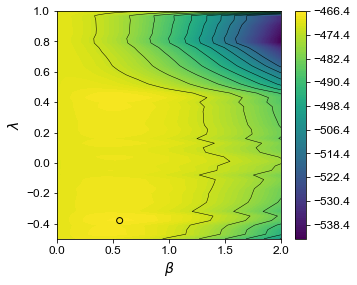

In [157]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)

xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax.contourf(xg, yg, M, levels = 100)
ax.contour(xg, yg, M, 
           levels = np.linspace(M.max()-50, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

ax.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

plt.tight_layout()

In [158]:
# the estimates are: 
ix = np.where(M == M.max())
# ix
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]
beta_hat, lambda_hat

(0.56, -0.38)

# Time-Series Visualization

Now that we have plausible(??) values for $\lambda$ and $\beta$, we can visualize time-series of $\gamma$.

In [144]:
T_ = T[t_start:,:,:]

years = np.arange(df_.t.min() + t_start, df_.t.max()+1)
lam = lambda_hat
n_rounds = T_.shape[0]
beta = beta_hat

# def plot_gammas(T, lam, title = '', figsize = (5,4)):
A = estimation.state_matrix(T_, lam, A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], beta)
    
top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

No handles with labels found to put in legend.


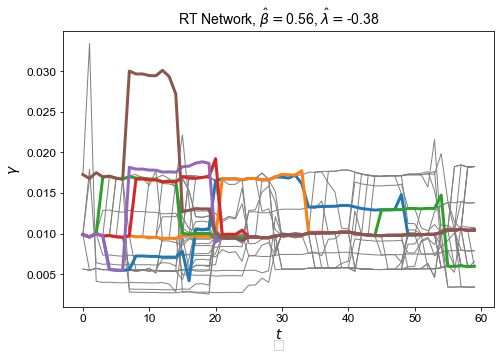

In [145]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)

k = 0
for l in range(n):
    ax.plot(years, GAMMA[:,l], color = 'grey', alpha = 1, linewidth = 1)

for l in range(n):
    if l in top_trajectories: 
        ax.plot(years, GAMMA[:,l], alpha = 1, linewidth = 3)
        k += 1
        
    ax.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'RT Network, $\hat{\beta} = $' + str(round(beta_hat, 2)) + r', $\hat{\lambda} = $' + str(round(lambda_hat, 2)))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=3)

plt.tight_layout()

# Comparison of several measures

# A prettier version

The code below just takes these two plots and combines them into a single figure, with some cosmetics. 

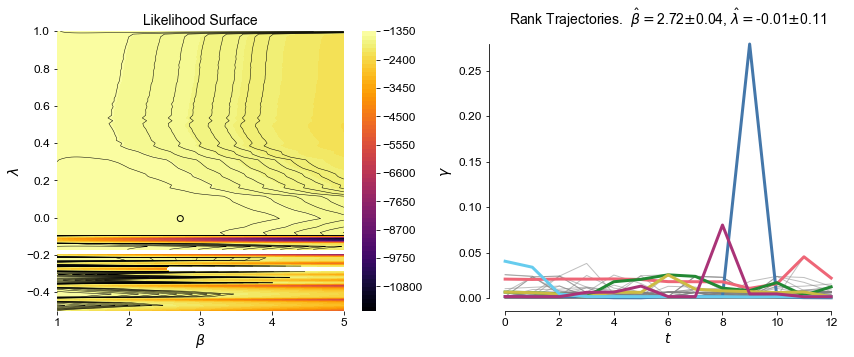

In [104]:

stderrs = np.sqrt(-np.diag(np.linalg.inv(estimation.hessian(M, BETA, LAMBDA)[ix])[0]))

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"



SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax1.contourf(xg, yg, M, levels = 100, cmap = 'inferno')
ax1.contour(xg, yg, M, 
           levels = np.linspace(M.max()-500, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

cb = plt.colorbar(im)
cb.outline.set_visible(False)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax1.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)

ax2 = fig.add_subplot(122)

shortener = {
    'Massachusetts Institute of Technology ' : 'MIT',
    'University of California, Berkeley ' : 'Berkeley', 
    'Stanford University ' : 'Stanford',
    'Princeton University ' : 'Princeton',
    'Harvard University ' : 'Harvard',
    'Yale University ' : 'Yale',
    'The University of Chicago ' : 'Chicago'
}

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

label_adjustments = {
    'MIT': 0.005,
    'Berkeley' : 0,
    'Harvard': -0.005,
    'Stanford' : 0,
    'Chicago' : 0,
    'Princeton' : 0
}

k = 0

for l in range(n):
    if l not in top_trajectories:
        ax2.plot(years, GAMMA[:,l], color = 'grey', alpha = .5, linewidth = 1)

for l in range(n):
    if l in top_trajectories: 
        ax2.plot(years, GAMMA[:,l], alpha = 1, linewidth = 3, color = cset[k])
        
#         ax2.annotate(shortener[lookup[l]],
#                   xy=(years.max(), GAMMA[-1:,l] + label_adjustments[name]), xycoords='data',
#                   xytext=(10, 0), textcoords='offset points',
#                   size=10, va="center", color = 'black',
#                   bbox=dict(boxstyle="round",  color = cset[k], alpha = .4)
#                   arrowprops=dict(arrowstyle="wedge,tail_width=1.",
#                                   fc=(1.0, 0.7, 0.7), ec="none",
#                                   patchA=None,
#                                   patchB=el,
#                                   relpos=(0.2, 0.5)))
#                     )
        
        
        k += 1
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_bounds(0, GAMMA.max())
ax2.spines['bottom'].set_bounds(years.min(), years.max())

ax2.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Rank Trajectories.  $\hat{\beta} = $' + str(round(beta_hat, 2)) + r'$\pm$' + str(round(2*stderrs[0], 2)) + r', $\hat{\lambda} = $' + str(round(lambda_hat, 2)) + r'$\pm$' + str(round(2*stderrs[1], 2)))

# ax2.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7),
#           fancybox=False, shadow=False, ncol=1, frameon = False)

# fig.suptitle('Math PhD Exchange', fontsize = 16)

plt.tight_layout()

plt.savefig('fig/rt-obama.png', dpi = 300, bbox_inches = 'tight')

In [51]:
stderrs

array([0.02218799, 0.01151801])